In [7]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
from galpy.orbit import Orbit
from scipy import integrate, interpolate
from scipy.integrate import quad
from optparse import OptionParser
import GMC_GC_util
import gd1_util
import pal5_util_MWfit
import MWPotential2014Likelihood
import numpy
import streamspraydf
import SCFbar_util_new, spiralarms_util
from galpy.df.streamgapdf import impulse_deltav_plummer_curvedstream
from gd1_util_MWhaloshape import lb_to_phi12

ro=8.
vo=220.

In [2]:
#n=9, l=19
Ac,As=SCFbar_util_new.compute_Acos_Asin()

barpot,nobarpot=SCFbar_util_new.MWPotentialSCFbar_grow(mbar=10.**10.,Acos=Ac,Asin=As,pat_speed=39.,fin_phi_deg=27.,t_on=-5.,tgrow=2,tstream=3.2)

spiral_pot=spiralarms_util.spiral_only_potential(tstream=3.2,axi_pot=nobarpot,N=4)

MW_bar_spiral_pot=barpot+[spiral_pot]
turn_physical_off(MW_bar_spiral_pot)

not growing spiral


In [5]:
#load the impacted sdf_pepper file

with open('GD1_64impact_only_subhalos_trailing_Plummer_td3.2Gyr_Mmin105_MW2014.pkl','rb') as savefile:
            sdf_pepper_imp= pickle.load(savefile,encoding='latin1')


new_orb_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]
sdf_smooth=gd1_util.setup_gd1model(leading=False,age=3.2,new_orb_lb=new_orb_lb,isob=0.45,sigv=0.3)
        


In [60]:
def compute_obs_density(phi1,apars,dens_apar,Omega):
    
    apar_edge=[]
    phi1_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    phi1bw0=phi1[1]-phi1[0]
    phi1_edge.append(phi1[0]-(phi1bw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        phi1bw=phi1[ii+1]-phi1[ii]
        apar_edge.append(apars[ii]+abw/2.)
        phi1_edge.append(phi1[ii]+phi1bw/2.)

    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
    phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dphi1=np.fabs(numpy.diff(apar_edge)/numpy.diff(phi1_edge))
    #print (dapar_dphi1)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(phi1)
    if phi1[1] < phi1[0] : # ad-hoc way of checking whether increasing or decreasing
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dapar_dphi1[::-1])
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],ipdens_apar(ipphi1(phi1[::-1]))*ipdapar_dphi1(phi1[::-1]))
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))
       
    return (dens_phi1(phi1))

def compute_dens_cont(phi1,dens_phi1,outphi1,deg=3):
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])

    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)

    #compute polynomial and density at outphi1
    ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=deg)

    #compute density contrast
    dens_cont=ip_dens_phi1(outphi1)/ppdens_phi1(outphi1)
    
    return (outphi1,dens_cont)

#plot the density in the streamdf framework
apars=np.arange(0.01,1.,0.01)
dens_unp= [sdf_smooth._density_par(a) for a in apars]
omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apars]
densOmega= np.array([sdf_pepper_imp._densityAndOmega_par_approx(a) for a in apars]).T
dens = densOmega[0] 
Omega = densOmega[1]

mT= sdf_pepper_imp.meanTrack(apars,_mO=Omega,coord='lb')
phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
phi1[phi1 > 180.]-=360.

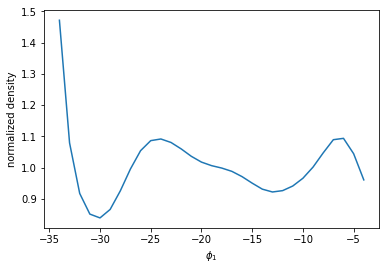

In [73]:
dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)

outp1=np.arange(-34.,-3.,1)

outphi1,dens_cont = compute_dens_cont(phi1,dens_phi1,outp1,deg=3)

plt.figure()
plt.plot(outphi1,dens_cont)
plt.ylabel("normalized density")
plt.xlabel(r'$\phi_{1}$')
plt.show()

In [75]:
o=Orbit(new_orb_lb,lb=True,solarmotion=[-11.1,24.,7.25],ro=8.,vo=220.)
#convert to galpy units
orb=Orbit(o._orb.vxvv)


Nsamples=100
spdft= streamspraydf.streamspraydf(10000*u.Msun,progenitor=orb,pot=MWPotential2014,leading=False,tdisrupt=3.2*u.Gyr)
RvR,dt= spdft.sample(n=Nsamples,returndt=True,integrate=False)
R=RvR[0]
vR=RvR[1]
vT=RvR[2]
z=RvR[3]
vz=RvR[4]
phi=RvR[5]

sorted_indx=np.argsort(dt)[::-1] #arrange in descending order to start with the star that was stripped first
#print (sorted_indx)

orbs_list=[[R[i],vR[i],vT[i],z[i],vz[i],phi[i]] for i in sorted_indx]
tstrip=[dt[i] for i in sorted_indx]
#print (orbs_list)
print (tstrip)


[88.00113206430903, 87.6697360887656, 86.45486729287512, 86.30916357217163, 83.94832724325488, 83.84993567630359, 82.62854389290058, 82.39641560501386, 82.25069124696607, 81.85512855775353, 77.76541479338911, 76.83936461629375, 76.83476795023128, 76.61809745082007, 76.49247986125106, 75.94864372544755, 73.32392969417509, 72.54496593684812, 71.75453137945073, 70.88651170104144, 69.26305588967196, 67.9425857804136, 66.62733198957933, 66.47609626977494, 66.06584673887372, 65.11710045501263, 65.10589873970088, 64.3061881130483, 63.47171276126299, 63.33755707329346, 63.09887051580603, 63.00828245991502, 61.65347856341065, 61.00317117989003, 59.70743644207465, 59.48116718726645, 57.954967353667406, 57.65702430142795, 56.730821693363694, 56.12586079859784, 54.44662678488192, 53.81148857586253, 51.47986355295817, 50.56786798416022, 50.11352585695198, 49.78122297125502, 47.33037481236524, 46.65582592948406, 46.5707134379539, 46.44103386262093, 46.3564414532237, 45.67548063673056, 45.58877382214

In [22]:
def star_propagator(tstar,orb,sdf_pepper_imp,pot):
    '''
    tstar : time from when to integrate the star's orbit
    orb : orbit of the star at tstar, must be an Orbit instance
    sdf_pepper_imp :sdf_pepper object
    pot : potential
    
    output:
    time of the next impact or 0 (for today), R,vR,vT,z,vz,phi 
    '''
    
    #timpacts starting from the 1 st impact time in the past, remove multiple impact times (repeated timpacts)
    unique_timp_rev = np.unique(sdf_pepper_imp._timpact)[::-1]
    #print (unique_timp_rev)
         
    if tstar <= unique_timp_rev[-1] : #if the star stripped after the last impact, simply integrate until today
        #print ("Integrating till today ")
        ts=np.linspace(-1*tstar,0,1000)
        orb.integrate(ts,pot)
        return (ts[-1],orb.R(ts[-1]),orb.vR(ts[-1]),orb.vT(ts[-1]),orb.z(ts[-1]),orb.vz(ts[-1]),orb.phi(ts[-1]))
    
    else:
        #determine the first timpact for this star
        next_timp_indx = np.where(tstar > unique_timp_rev)[0][0] #this gives the actual index (starting at 1), but in python it's
        #print ("next_t ind",next_timp_indx)
        # the following index, which is what we need. 
        timp_next= unique_timp_rev[next_timp_indx]
        #print (tstar,timp_next)
        ts=np.linspace(-1.*tstar,-1.*timp_next,1000)
        orb.integrate(ts,pot)
        x=orb.x(ts[-1])
        y=orb.y(ts[-1])
        z=orb.z(ts[-1])
        vx=orb.vx(ts[-1])
        vy=orb.vy(ts[-1])
        vz=orb.vz(ts[-1])
        #print ("xyz",x,y,z,vx,vy,vz)
        #R,vR,vT,z,vz,phi=rect_to_cyl_orb(x,y,z,vx,vy,vz)
        R,vR,vT,z,vz,phi=impact_stream(timp_next,x,y,z,vx,vy,vz,sdf_pepper_imp)
        return (timp_next,R,vR,vT,z,vz,phi)
               

def cyl_to_rect_orb(R,vR,vT,z,vz,phi):
    x,y,z = bovy_coords.cyl_to_rect(R,phi,z)
    vx,vy,vz = bovy_coords.cyl_to_rect_vec(vR,vT,vz,phi)
    
    return x,y,z,vx,vy,vz

def rect_to_cyl_orb(vx,vy,vz,x,y,z):
    R,phi,z = bovy_coords.rect_to_cyl(x,y,z)
    vR,vT,vz = bovy_coords.rect_to_cyl_vec(vx,vy,vz,R,phi,z,cyl=True)
    
    return R,vR,vT,z,vz,phi

def impact_stream(timp,x,y,z,vx,vy,vz,sdf_pepper_imp):
    
    '''
    This function takes the time of impact and the 6D coordinate of the star at that time and computes the delta v and
    adds that to the velocity of the star and outputs the kicked 6D coordinate back in cylindrical coordinates. 
    This takes into account multiple impacts at the same time. 
    
    timp : time of impact from _timpact 
    sdf_pepper_imp : impacted sdf object 
    
    '''
    timp_all = sdf_pepper_imp._timpact
       
    #obtain the indices of timp in the timp_all list, multiple impacts are also considered 
    nimp_indx=[i for i,mem in enumerate(timp_all) if mem == timp]
    
    dv=np.zeros(3)
    for jj in nimp_indx:
        #print (jj)
        dv+=impulse_deltav_plummer_curvedstream(np.array([[vx,vy,vz]]),np.array([[x,y,z]]),
                                sdf_pepper_imp._sgapdfs[jj]._impactb,
                                sdf_pepper_imp._sgapdfs[jj]._subhalovel,
                                sdf_pepper_imp._sgapdfs[jj]._kick_ObsTrackXY_closest[:3],
                                sdf_pepper_imp._sgapdfs[jj]._kick_ObsTrackXY_closest[3:],
                                sdf_pepper_imp._GM[jj],sdf_pepper_imp._rs[jj])[0]
        
     
    vstr=np.array([vx,vy,vz])+dv
    kicked_coord = [rect_to_cyl_orb(vstr[0],vstr[1],vstr[2],x,y,z)][0]
    #print ("kicked",kicked_coord)
    return kicked_coord
    


In [76]:
final_coords=[]

for ii in range(len(orbs_list)):
    tss=tstrip[ii]
    oorb=orbs_list[ii]
    
    while tss != 0. :
        #print (tss)
        tss,Rs,vRs,vTs,zs,vzs,phis = star_propagator(tss,Orbit(oorb),sdf_pepper_imp,MWPotential2014)
        oorb=[Rs,vRs,vTs,zs,vzs,phis]
        #print (tss,Rs,vRs,vTs,zs,vzs,phis)
        
    final_coords.append(oorb)
    #print ("final",final_coords)
    

In [24]:
def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)

def galcencyl_to_phi12(R,phi,Z,degree=True):
    l,b,d=np.array(galcencyl_to_lbd(R,phi,Z))
    phi12=lb_to_phi12(l,b,degree=True)
    phi1=phi12[:,0]
    phi1[phi1 > 180.]-=360.
    phi2=phi12[:,1]
    return (phi1,phi2)

In [77]:
#R,vR,vT,z,vz,phi

Rt=[final_coords[ii][0] for ii in range(len(final_coords))]
phit=[final_coords[ii][5] for ii in range(len(final_coords))]
zt=[final_coords[ii][3] for ii in range(len(final_coords))]


#simply integrate in the bar+spiral pot
Rt_noimpact=[]
phit_noimpact=[]
zt_noimpact=[]

for jj in range(len(orbs_list)):
    ts=np.linspace(-tstrip[jj],0.,1000)
    o=Orbit(orbs_list[jj])
    o.integrate(ts,MWPotential2014)
    Rt_noimpact.append(o.R(ts[-1]))
    phit_noimpact.append(o.phi(ts[-1]))
    zt_noimpact.append(o.z(ts[-1]))
    

p1_t,p2_t=galcencyl_to_phi12(Rt,phit,zt)
p1_t_noimpact,p2_t_noimpact=galcencyl_to_phi12(Rt_noimpact,phit_noimpact,zt_noimpact)

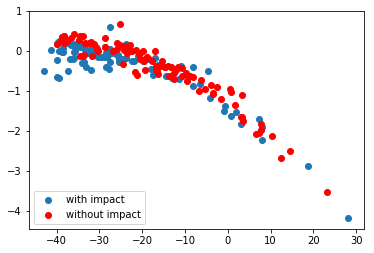

In [78]:
plt.figure()
plt.scatter(p1_t,p2_t,label='with impact')
plt.scatter(p1_t_noimpact,p2_t_noimpact,color='r',label='without impact')
plt.legend(loc='lower left')
plt.show()

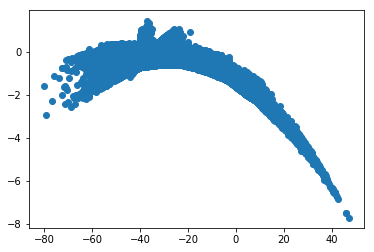

In [83]:
#R   phi   z   vR    vT    vz
Rdat=[]
phidat=[]
zdat=[]

for ii in range(1000):
    R,phi,z,_,_,_=np.loadtxt("sample_spraydf_subhalos/MWPotential2014/sample_spraydf_subhalos_N100_MWPotential2014_GD1stream_trailing_batch{}.dat".format(ii),unpack=True)
    for jj in range(len(R)):
        Rdat.append(R[jj])
        phidat.append(phi[jj])
        zdat.append(z[jj])
    
    
p1_dat,p2_dat=galcencyl_to_phi12(Rdat,phidat,zdat)

plt.figure()
plt.scatter(p1_dat,p2_dat)
plt.show()

In [68]:
from numpy.polynomial import Polynomial
def compute_ndenphi1(phi1,maxphi1=-42,minphi1=-60.,bw=2.,polydeg=3):
    N=len(phi1)
    print (N)
    
    nbins= (maxphi1 - minphi1)/bw
    print ("no of xi bins = %i"%nbins)

    phi1bin_edge=[(minphi1-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midphi1=[0.5*(phi1bin_edge[i] + phi1bin_edge[i+1]) for i in range(int(nbins)+1)]
    
    Ndn=np.histogram(phi1,phi1bin_edge)[0]
    print (np.sum(Ndn))
    Ndn_err=numpy.sqrt(Ndn)
       
    pp= Polynomial.fit(midphi1,Ndn,deg=polydeg,w=1/(Ndn_err))
    nden=Ndn/pp(np.array(midphi1))
    nden_err=np.sqrt(Ndn)/pp(np.array(midphi1))
    return (midphi1,Ndn,Ndn_err,nden,nden_err,pp(np.array(midphi1)))

100000
no of xi bins = 30
58230


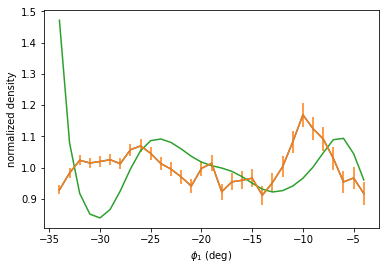

In [84]:
midphi1,Ndn,Ndn_err,nden,nden_err,pp = compute_ndenphi1(p1_dat,maxphi1=-4.,minphi1=-34.,bw=1)
plt.figure()
#plt.plot(midphi1,Ndn)
plt.plot(midphi1,nden) 
plt.errorbar(midphi1,nden,nden_err)
plt.plot(outphi1,dens_cont)
plt.ylabel('normalized density')
plt.xlabel(r'$\phi_{1}$ (deg)')
plt.show()

In [ ]:
#Load the stream objects

timescdm = '3.2'
arm = 'leading'
sigv='0p3'
td=3.2


with open('pkl_files/pklfiles_{}Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(td,arm,td),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')
            
print (sdf_pepper._timpact)

In [ ]:
#Remember, the timpacts are in reverse
#so subtract 3.2 Gyr (in galpy units), negative sign indicates in the past

timp_past = -1.*sdf_pepper_imp._timpact[::-1]

print (timp_past)

from collections import Counter
mult_imp = Counter(timp_past)


print (mult_imp.get(timp_past[0]))

print ([i for i,x in enumerate(timp_past) if x == timp_past[2]])

print (sdf_pepper_imp._timpact[::-1])

print (np.unique(sdf_pepper_imp._timpact))

In [ ]:
aa=np.unique(sdf_pepper_imp._timpact)[::-1]
print (aa)

gt=aa[31]
print (gt)

print (np.where(gt>aa)[0][0])





In [ ]:
for ii in range(len(tstrip)):
    ts=tstrip[ii]
    for jj in range(len(timp_past)):
        if ts > timp_past[jj]:
            print ("integrate orbit",ts,timp_past[jj])
            
        else:
            print ("set_impacts",ts,timp_past[jj])

In [ ]:
deltav=impulse_deltav_plummer_curvedstream(np.array([[0.1,0.2,0.1]]),np.array([[0.2,-0.1,-0.2]]),
                            sdf_pepper_imp._sgapdfs[0]._impactb,
                            sdf_pepper_imp._sgapdfs[0]._subhalovel,
                            sdf_pepper_imp._sgapdfs[0]._kick_ObsTrackXY_closest[:3],
                            sdf_pepper_imp._sgapdfs[0]._kick_ObsTrackXY_closest[3:],
                            sdf_pepper_imp._GM[0],sdf_pepper_imp._rs[0])

print (deltav)

In [ ]:
aa=np.array([1,2,3,4,5,6,7,8,9])

print (aa.shape)